In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

## Load the Data

In [ ]:
train_data = pd.read_csv('./train_data.csv')
val_data = pd.read_csv('./val_data.csv')

## Preprocessing function


In [ ]:
def preprocess_data(data, encoder=None, scaler=None):
    categorical_features = ['distributor_id', 'industry', 'sku', 'category', 'movement_category']
    numerical_features = ['sales', 'avg_quarterly_sales', 'total_quarter_sales', 'prev_quarter_sales',
                          'is_diwali', 'is_ganesh_chaturthi', 'is_gudi_padwa', 'is_eid',
                          'is_akshay_tritiya', 'is_dussehra_navratri', 'is_onam', 'is_christmas', 'time_idx']

    # One-hot encoding for categorical features
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False)
        encoded_categorical = encoder.fit_transform(data[categorical_features])
    else:
        encoded_categorical = encoder.transform(data[categorical_features])

    # Scaling numerical features
    if scaler is None:
        scaler = StandardScaler()
        scaled_numerical = scaler.fit_transform(data[numerical_features])
    else:
        scaled_numerical = scaler.transform(data[numerical_features])

    # Combine processed features
    processed_data = np.hstack((encoded_categorical, scaled_numerical))

    print(f"Processed data shape: {processed_data.shape}")
    return processed_data, encoder, scaler

## Extract extra columns before encoding


In [ ]:
extra_columns = ['sku', 'distributor_id', 'industry', 'category']
extra_data_train = train_data[extra_columns].reset_index(drop=True)
extra_data_val = val_data[extra_columns].reset_index(drop=True)

## Preprocess train and validation data


In [ ]:
X_train = preprocess_data(train_data)
y_train = train_data['sales'].values  # Target variable
X_val = preprocess_data(val_data)
y_val = val_data['sales'].values  # Target variable

### Fit encoders/scalers on training data

In [ ]:
X_train, encoder, scaler = preprocess_data(train_data)
X_val, _, _ = preprocess_data(val_data, encoder, scaler)

### Check for GPU


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class TFTModel(nn.Module):
    def __init__(self, input_size):
        super(TFTModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SalesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx], dtype=torch.float32),
                torch.tensor(self.targets[idx], dtype=torch.float32))

## Create datasets

In [ ]:
train_dataset = SalesDataset(X_train, y_train)
val_dataset = SalesDataset(X_val, y_val)

### Create data loaders


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Initialize model, loss function, and optimizer


In [ ]:
input_size = X_train.shape[1]
model = TFTModel(input_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Early stopping parameters

In [ ]:
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

### Training the model

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)  # Move data to GPU
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        early_stop = True
        break

Epoch 1/100, Validation Loss: 145230254.4681
Epoch 2/100, Validation Loss: 46112721.0957
Epoch 3/100, Validation Loss: 10710226.7766
Epoch 4/100, Validation Loss: 5164707.9488
Epoch 5/100, Validation Loss: 4207616.6024
Epoch 6/100, Validation Loss: 3809369.2739
Epoch 7/100, Validation Loss: 3459901.7759
Epoch 8/100, Validation Loss: 3226510.3291
Epoch 9/100, Validation Loss: 2835023.6336
Epoch 10/100, Validation Loss: 2527740.1223
Epoch 11/100, Validation Loss: 2252918.3132
Epoch 12/100, Validation Loss: 1996481.8334
Epoch 13/100, Validation Loss: 1749913.7394
Epoch 14/100, Validation Loss: 1526982.9970
Epoch 15/100, Validation Loss: 1345112.1350
Epoch 16/100, Validation Loss: 1119983.0336
Epoch 17/100, Validation Loss: 969486.6145
Epoch 18/100, Validation Loss: 801504.5256
Epoch 19/100, Validation Loss: 668462.7324
Epoch 20/100, Validation Loss: 569382.0326
Epoch 21/100, Validation Loss: 449821.5145
Epoch 22/100, Validation Loss: 366788.1049
Epoch 23/100, Validation Loss: 290831.7886


In [4]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Ensure model is on GPU
print("Training complete. Best model loaded.")

NameError: name 'model' is not defined

In [5]:
# Ensure model is in evaluation mode
model.eval()

# Store predictions
predictions = []
actual_sales = []

with torch.no_grad():
    for features, targets in val_loader:
        features, targets = features.to(device), targets.to(device)  # Move to GPU
        outputs = model(features)  # Forward pass

        # Move outputs to CPU before converting to numpy
        predictions.extend(outputs.squeeze().cpu().numpy())
        actual_sales.extend(targets.cpu().numpy())

# Convert predictions to DataFrame
predictions_df = pd.DataFrame({
    'Predicted Sales': predictions,
    'Actual Sales': actual_sales
})

# Add extra identification columns back to the predictions DataFrame
predictions_df = pd.concat([extra_data_val, predictions_df], axis=1)

# Display first few rows
print(predictions_df.head())


NameError: name 'model' is not defined

In [6]:
predictions_df.find()

NameError: name 'predictions_df' is not defined

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Switch to evaluation mode
model.eval()

# Collect predictions and actual values
y_true = []
y_pred = []

with torch.no_grad():
    for features, targets in val_loader:
        features, targets = features.to(device), targets.to(device)  # Move to GPU
        outputs = model(features).squeeze()

        # Append to lists (move to CPU for numpy calculations)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print results
print("\n📊 Model Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R² Score = {r2:.4f}")


NameError: name 'model' is not defined

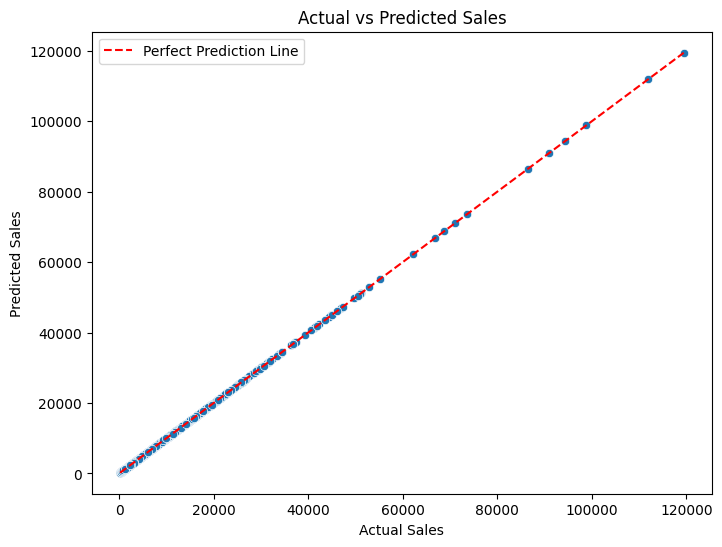

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Actual vs Predicted Sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_df['Actual Sales'], y=predictions_df['Predicted Sales'])
plt.plot([predictions_df['Actual Sales'].min(), predictions_df['Actual Sales'].max()],
         [predictions_df['Actual Sales'].min(), predictions_df['Actual Sales'].max()],
         color='red', linestyle='--', label="Perfect Prediction Line")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()


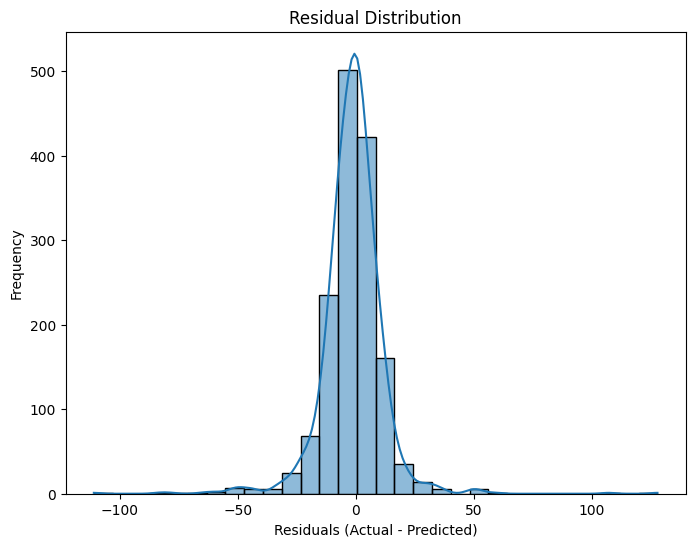

In [ ]:
# Residual Plot: Prediction Errors
residuals = predictions_df['Actual Sales'] - predictions_df['Predicted Sales']
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

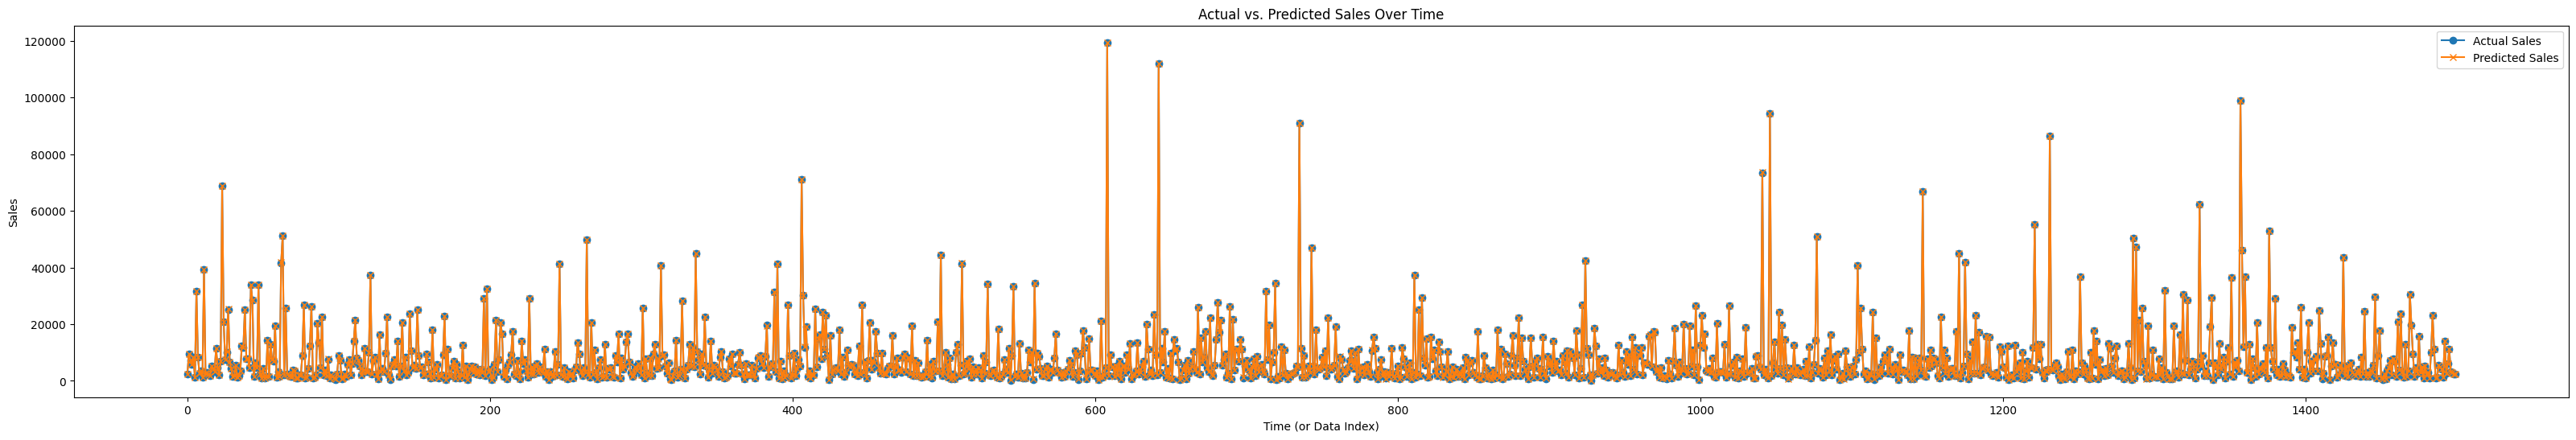

In [ ]:
# If your sales data is time-based, visualize predictions over time
plt.figure(figsize=(40, 6))
plt.plot(predictions_df.index, predictions_df['Actual Sales'], label="Actual Sales", marker='o')
plt.plot(predictions_df.index, predictions_df['Predicted Sales'], label="Predicted Sales", marker='x')
plt.xlabel("Time (or Data Index)")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales Over Time")
plt.legend()
plt.show()